/var/folders/ln/kls56lq93mq4z_459sxk1vbh0000gn/T/ipykernel_84896/3050839609.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER)
[*********************100%***********************]  1 of 1 completed


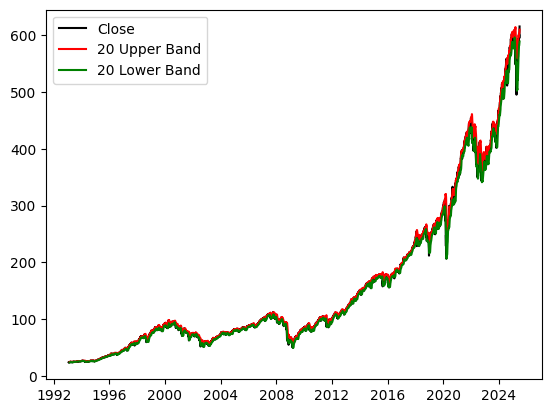

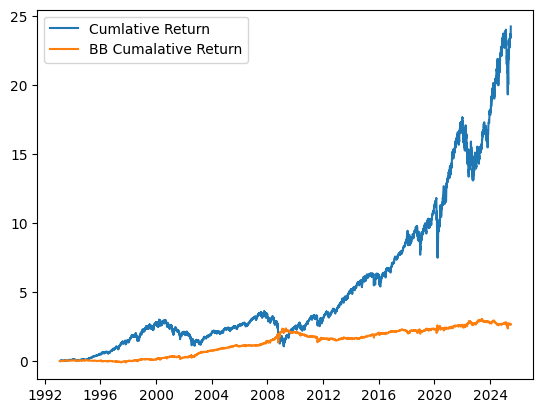

In [33]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TICKER = "SPY"
BB_LENGTH = 20
DEV = 1.5
LOOKBACK = 10000


def get_data():
    df = yf.download(TICKER)
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]


def add_bb(df, dev=DEV, bb_len=BB_LENGTH):

    df[f"{BB_LENGTH}_EMA"] = df["Close"].rolling(bb_len).mean()
    df[f"{BB_LENGTH}_STDDEV"] = df["Close"].rolling(bb_len).std()

    df[f"{BB_LENGTH} Upper Band"] = df[f"{BB_LENGTH}_EMA"] + (dev * df[f"{BB_LENGTH}_STDDEV"])
    df[f"{BB_LENGTH} Lower Band"] = df[f"{BB_LENGTH}_EMA"] - (dev * df[f"{BB_LENGTH}_STDDEV"])

    df.dropna()

    plt.plot(df["Close"], color="k")
    plt.plot(df[f"{BB_LENGTH} Upper Band"], color="r")
    plt.plot(df[f"{BB_LENGTH} Lower Band"], color="g")
    plt.legend(
        [
            f"Close",
            f"{BB_LENGTH} Upper Band",
            f"{BB_LENGTH} Lower Band"
        ]
    )

    return df


def add_strategy(df):
    df["Strategy"] = np.where(
        df["Close"] > df[f"{BB_LENGTH} Upper Band"], -1, np.where(df["Close"] < df[f"{BB_LENGTH} Lower Band"], 1, 0)
    )
    df["Strategy"] = df["Strategy"].shift(1)
    return df


def test_strategy(df):
    df["Cumalative Return"] = np.cumprod(1 + df["Close"].pct_change()) - 1
    df["BB Cumalative Return"] = (
        np.cumprod(1 + df["Close"].pct_change() * df["Strategy"]) - 1
    )

    plt.figure()
    plt.plot(df["Cumalative Return"])
    plt.plot(df["BB Cumalative Return"])
    plt.legend([f"Cumlative Return", f"BB Cumalative Return"])
    return df


def main():
    df = get_data()
    df = add_bb(df)
    df = add_strategy(df)
    df = test_strategy(df)


main()